In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Keras setup

In [2]:
# convert to one-hot encoding
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


### Data loading

In [3]:
train_file = "data/train.csv"
test_file = "data/test.csv"
output_file = "submission.csv"

### Split training data as training set and validation set

In [4]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')

# x is data, y is label
x_train, x_val, y_train, y_val = train_test_split(
                                    raw_data[:,1:], 
                                    raw_data[:,0], 
                                    test_size=0.1)
print(len(x_train))
print(len(x_val))

print(len(y_train))
print(len(y_val))

37800
4200
37800
4200


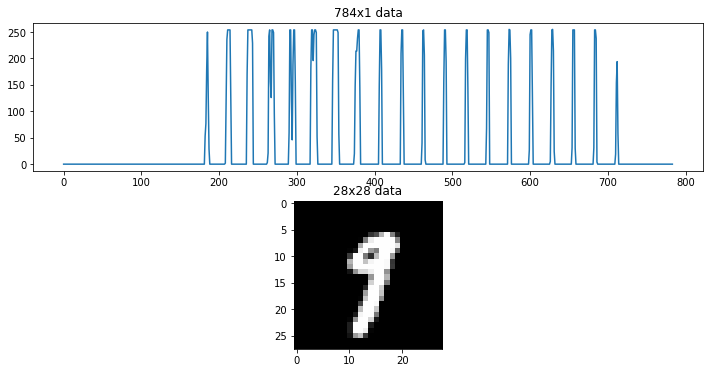

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title("784x1 data")
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title("28x28 data")

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

# convert 0-255 to 0-1, converge faster. why
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. 

In [7]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


### Network building

BN and Dropout used

In [8]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# data augmentation
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)


model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
# to reduce the learning rate by 10% every epoch.
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/20
 - 23s - loss: 0.7905 - acc: 0.7460 - val_loss: 0.0734 - val_acc: 0.9775
Epoch 2/20
 - 20s - loss: 0.3055 - acc: 0.9078 - val_loss: 0.0587 - val_acc: 0.9825
Epoch 3/20
 - 21s - loss: 0.2632 - acc: 0.9230 - val_loss: 0.0481 - val_acc: 0.9875
Epoch 4/20
 - 21s - loss: 0.2176 - acc: 0.9371 - val_loss: 0.0301 - val_acc: 0.9900
Epoch 5/20
 - 22s - loss: 0.1846 - acc: 0.9467 - val_loss: 0.0296 - val_acc: 0.9925
Epoch 6/20
 - 20s - loss: 0.1717 - acc: 0.9517 - val_loss: 0.0342 - val_acc: 0.9950
Epoch 7/20
 - 20s - loss: 0.1464 - acc: 0.9577 - val_loss: 0.0281 - val_acc: 0.9875
Epoch 8/20
 - 20s - loss: 0.1333 - acc: 0.9612 - val_loss: 0.0228 - val_acc: 0.9925
Epoch 9/20
 - 19s - loss: 0.1245 - acc: 0.9634 - val_loss: 0.0120 - val_acc: 0.9975
Epoch 10/20
 - 19s - loss: 0.1183 - acc: 0.9659 - val_loss: 0.0146 - val_acc: 0.9950
Epoch 11/20
 - 19s - loss: 0.1060 - acc: 0.9680 - val_loss: 0.0122 - val_acc: 0.9950
Epoch 12/20
 - 19s - loss: 0.0934 - acc: 0.9724 - val_loss: 0.0070 - val_a